<a href="https://colab.research.google.com/github/TamizharasanG/Transfer_Learning/blob/main/Transfer_Learning_MobileNet_V2_%3E_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning Using MobileNet V2 model for flowers dataset**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL.Image as Image
import os
import cv2
import pathlib
import urllib.request

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

**Importing the pretrained model for usage**

This is a famous model for **image classification** contributed by ***Google***. This model is trained over **1.4 million** images with *1000 classes*. So we can use this model with slight updation for the better performence of our custamized model with least amount of time and computation

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

-->> Getting the names of the 1000 classes and storing in a numpy array

In [5]:
df_labels = pd.read_fwf("https://github.com/codebasics/deep-learning-keras-tf-tutorial/raw/master/18_transfer_learning/ImageNetLabels.txt")
labels = np.array(df_labels.iloc[:, 0])

In [6]:
labels[:10]

array(['tench', 'goldfish', 'great white shark', 'tiger shark',
       'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich'],
      dtype=object)

**Getting a image of gold fish for verifyinng the model performance**

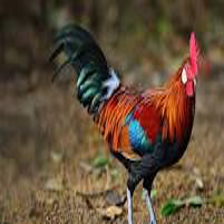

In [7]:
urllib.request.urlretrieve(
  'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBwgHBgkIBwgKCgkLDRYPDQwMDRsUFRAWIB0iIiAdHx8kKDQsJCYxJx8fLT0tMTU3Ojo6Iys/RD84QzQ5OjcBCgoKDQwNGg8PGjclHyU3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3N//AABEIAHEAyQMBIgACEQEDEQH/xAAbAAADAAMBAQAAAAAAAAAAAAADBAUAAQIGB//EAEQQAAIBAwIEBAIGBwQJBQAAAAECAwAEERIhBTFBURMiYXGBkQYUMnOhsRUjMzXB0fA0QnKyJENSU1R0gpLhNkViY7P/xAAaAQADAQEBAQAAAAAAAAAAAAAAAQIDBAUG/8QAKxEAAgIBAwMCBAcAAAAAAAAAAAECEQMSITEEQVETYRQiMnEFNEJDgZHR/9oADAMBAAIRAxEAPwD5OxGdjWjtXcMYI3FMeCCOVZF2Lo2DTUUqD7VDEBztXM1swXIoAJeaWAKmi2setAAN6QUMBhjvVCzmEIy5xihidhouDySvnvRLrhpt499zVXh1/b6CWIoN7exzZMcbsvc7CkkxKSXJ5llYOdqetiyqSw2oVzNH4mWjYDuN6eilgkh0wyK7Y+ydj8qHfgpSQjJNmUU9A5IwKlTI/jHbAzVOyjIGrtSYx0WuYwzHc1Nmj0ylRT0s8oj8ozSsWoudeM1KBmRx43oupsYzitljnAXNEWIumaWqhJikkZfOSaXRTC3OnXjZD5j5a5iiWSQAnNDkkN8WHt3EiYat5RW2G9NCyAiypqbdRNG5y21RCSYJ2NSMWj2pTxCsmD1rmO7SNMMc1iSxzPt71dF2MuniLj0pNrR13zT0TdqOUVlBJpatxSexIIKciazU3+0fnVk2SuudtxQ/0d7VVkI8/GSCdqKrHkeVd22gudVNOkbDAxVtjALIBzNEXTIuM0E2471xG/hSbnajkdhJIQj4FCddROkZopdScmhzXIhX9Uup22A6fGhWJnSlo4SZpVgj9sk1oyWaxjU9xIrDIPL5ij8L4Yt7KJb+UueehTt/XtTHE7WztzohYM3IQjcitIzV0YyjW5L0wucRyOvbNLTaVbBYEjqtHuhHEmi2idpP7zNsPYUgqk7yNnPwq9yUPW96hYJM23Rj0r0VoiGMEbgjYivJSQlQCysM8sjn8ae4LxJrSYRSNmBj1/uHv7VlON8G0ZHoZiiDdT8qFHGr5bGM0+pimTOoE+vStrAuPKc+1YOy6FlhTA2rC4QEBaLIujINBU6m0ioa8jVHCReM5PStG0KODjbNMvDKgyq/KtJNuFfnRsDgzuR2SMKR5elCEK3Q8y71UhhS4i5gntQBwy6Ev6rYUtkUtuSJe8LA/ZirPBeEon0dundf1spbHl3XHID5fjR2txaYN5JjPIdSaocOuopg1sEePQxGHG+/t8auE3dHpfhuGOTLutqZ44oYLgrJjY4qi0v6sBE1Ue+sEmkDxYCL5VAOc+uep60xw+K3RdEpGR3p2cOXDpm0uBGGZ/73kAovjL3qrcQWrxFV00j+j4vSo1PwZ6UeM3Wuo1kdscqoiBNY8tdOETdVxXTaIonlZ02G9Es7R52JbanVlXTyz8K4iacOfDjYA9TUtgkAntAG0g0D6njJJ2HM1YW0kYa25mtiyDgiQZU8xS1DonWEcjApGzKh5tyJHp2p9Ioo4yqjBJ+fv3ruW0P+rOB2FDhtS841k4HrVaidInc8OLyxpZozvKwUInMk9qPx3h1jwQxQuzXF66+ZUO+r26CqxvhwMNd2qRm4CFI3b/Vltsgd8E/Oh8NZbi8lk4Bw+S8nk+3fX+GC998YHsPStcbbjZy53pl7HlxZzyoZXjSFDuFd8s3sBU6ddDEFgPZuVeu41az+IwnvLa5lzp0QJnfsMVMsbyPgso+scLW7uCcrHKMaf41aRMJ29i99FbBuMWEqRa1vFUFNakKx7Z5cu1cwTTQXb2k8TRzIxUqwI+Ne5X6S2/BeDW13xGxhjkmA8G2t0yzewO9eNu+Ptxnjf1u9xaoqhI4I4/FkY55sF3BO21LPCEVtydOFTm/YYHDJpzrcgCsW2jibcAkVjcVmKFAIQckbSA4Hr2NLwzpJqLuSTsNKlt/THOuX2N3jaHxKrroVcUKXhLsplGPbFNWtjIyA7Rk8hIcE/CqiJOIfBdQCdhyH5kVD0x5LWPJJWkQrDVE2GXbNVpeJRWlsz+GGIGwO341ylrpDA4155sRj2GCaSu5Y0YqUWdQBp1DKk+g/rvXNlzLiKOzp+j1b5Cz9EuEHjdhxLi87MZrchbdNIUHA1NkdiDgdeZ60i8cWpbxXUuoy/LJA67c+vyqX+meI8Le5isL17aG6cLIE6gHTt2ONsjG1buJDwmSxu4FSMCRkYY2cMhAB7jl+Fb42pRVHpYVPp1OarbgBeTHx5GjP6tmLL8amS3MgY6etWpoAFC6cBRjFLwxRFt0/CtKp2eHPPKd+5Oga5kYjUR8aY8O6/wB5+FNSvHEcooHwrj64P9gfKqtGFCsccYPl3rb24bfApRQ65w1Z4suPtUwseitYzyA+FMtGsaZYcqmJcSKdmppZ2liKuc0hBxOgXY5HtWjIrJkClbePzFQc0wNKjSQCRSZSNxSrnBWtIMzYXqa6VdPnK5U0YhV868+eKllC/EeGwXcJhm2zvlTjBqHe2XGrO0a3guQnD449TyAlV9RjOc/zq3I7aw7Hc9KYeUy25ikjDI4wVO4IpxyOBMsUZ8nneH3cnDeGhbVc8Sny0kzNjwk6KCeXXPU7U4iXltBBoZBfykZ0xjKZ6MTnc7DAol/wpY2SW2tk06GLad3LbY59N6YiaSCa2hZf9IBCjUOczDcnvpBG/pRPqNK+Tk16fpYylc+AXE7W+uZAZ5pLi5ddJmdt8dQvRV7nrVDhvDUtLFEdy0uks4iXG3QA9vXmfTmW5FESu8qnQqhu2oA+RfbqfUgUeynE4DvKqRoCDIRgyMu2d+Sgg4HpmvOebLI92UMMFxVCNxi2iZ7jwxoHm22i7KNsk+nP07SmikuHjmV2Vc5xqCttnfsg9geVW5LIcSVorZGAUEh3JAGei+p3y3M/KpnEuCXVjbPcTyxspwrBRjfsR2Ar0/hssMet7/bseXh6/pc2f0m9L7J8v/Af6YKIqFXXSMZ8RmLc/UZ92J9qNa8WiS3eW6XRgYSJNsk9NuneoW7HGpdzQpXZPMpB08j2rjkvU5PWeOEFcT2dk8ISJpw/jXOoAMcsYx9rAGyjpgfGmOJIsX+ksp0R74HX+sGvH8O4hctGt3IwIhiMKAj+7vk/Mk/KvS/SDiCZu7YHOSrL7Y3riy4pQyJCxZVONoifSCZxEgz58EkjqcZqBaLLPxKFPEcrHLGMaiQPMBypni154pZW+0p/icfgaF9Go2uOOALuqjW23bl+OK9TBFxjuef12RPg+k3SIVyhBPap2oR5BG9AZbjxTpLb0KVJ9eGOaqzzQ7QibBNZ9RSgt40cZ5+lceLcd6aQELUytjNEXWeZ2rAmliGUgjrRA2NhVtkJApSVbAFHjWQLnpRo1jfdhR2KiMgDpU6h0IiVkYkc+lFSViDq5k5rUMXiPvtTsFkstwqagDjrQ2CCW5MqBVo8cPm1HfHSiNw26tTllAUb5zQY5lldvNsDtWRaaOL6BVXXn4dq5tl8Yjz7UURSSyHqnrR/qekK2VVedTJ7UUkbaCONyJ5AcjbelwgW6hmknDwW4ebwtGWZ98YPxpu6jhkCspLueQFGW2UQlmiIYDrWOnk1jl0SW55vh/Erji/GGhmULCJs4HRVycfML/204lxniBtkQaLYAZP+2Rz/AB/E0neLdcLvDfxWfjwsPMq8xvvQOF8c4bc8QYTFrOSVm1vO/kyTnGQNvjiqngk94Lajsh1ePTUnvZ6uK/e2Kr4gGd9OOf8AXuKN+kre4jMLa5GZiFjQcydufIZJ/wDNIcS4RcXFlpiiV0bdJ1lynzyP6NeMvLTjfD2SWSJjGh2kgOoA9zjf4163QdXGPTrDPlHz/wCJ9D6vUPNj7lfjvDjbXLJbwoVG7eG22T0BPblUKSXVGy5CgelbkfibRLqGkDc62wcUIfq4Bpbc7s8Zz8M1m8Edeo68fX51g9KXPkZub+OPhcdujZkKAnA7tk/hXPEOJC5uIJNR1aTn12xUafHiac571gkWIHSAM8t6j4eN2aLrciVfYNeT5lJPX869T9BoGgt5LloWLXBChsclH8z+VQfo9wKbjVxqkJS0Q+d8fa/+I9fyr6RDH4UPhIulUXGAMACssklBaUJylkk5M1lixCgau1CjtyyPJKcvnpTCsqqXUEOO/WuZ5WjJ0jbq3asrHQukTMRr+wDvTHgW39ChozyJojzjmTXHhy9x8qpbi4JKprYqwArLuBVTFGRCj77rnnXU8DzEvyHamTRJUuCQOlNQrqUgnLYqlFbQ4AcVtbNBL+rAOOYp6kFE6G1lMmwOmnooNMmrSdQ6106FpAoYoAdgDzqvw+ztVj/XXKlzvgvipe4VTEmlluTHCS5UnBpVLNVJwpVVcjvXojBCkbmExsrAt9rrUewd1MkdzIilidh1Pesky1RqFWbWirspzv1FMxrZ3CMsymHSNyDkU1a2cjPqOAp6550P6gsYSTGVaXLZPM0KSSK02K20ZAc8LeNgPL4kgxU0vOb3w7u7kePUA5hTOM+temNsmqSB5QiMcjHMLQYeGWsEgt7dgC5y5zz9TRqXgyeFN7iI4dfNK9uul4Ubyamxj3pXiv0ctL6NjNCsdyPL46c/j0NVONvb/XUYzooQ48hyW+VbMqzQOkSSKMjSzDbPempOPA9L/g+bJZXfBr8wy3E0eoE+PbOyhgNhkjHyo8lzeMdUt3NOOY1Tkg+/myaf+ld/c2l+YLiEeA0QMQK7OudyD7gj0oHDOEvxGGO4v2+r2TeZIEPmcHB3zyHrzruUkopyMHFuVIlTXujmoJ6AP/MUpbrc8RnMdtC08uMlUGcDuT0pfiFpcW948Vzby27azpjkBGBnlvzr6VwHhNvw7hMCxGRbhkLzSBN3YdPbtRly6FYQhq2PFD6McTYAmDQScY5mqNt9D54sSXNsZm6AyYX8P517lr5QoluYyjqMYG57fOg2t2reMrs6Y3XJyflXG885HQscUIcPe7jWNZrRI1TZFjGwFVEeS7lEJIiDc2bkfSkGv47vMSa0iDYDHyhiOdFtb95G8K3SNYoz5jIMkDqamPiinaG54mglVJnRnPIjlS8Fs11cyJ46qnY8qLxbinApbHxLW4iW9icfqH31e1TLa+jkmPjFFQsAAnUnlRpa4EnZXddM4gXyrjBPQGu/qi/78fKpN0kkUwQTkO2XJJ39BWvqt7/xLU6XkLONImQrENK7faosR8gL43BBxU6AeHGjnXqkJPfGKYa5ZHQIqqpHnLjOCap32JXkKrnVpGGOdyKHdMyFHZwNAOoe1dPlJlXRrJ7Hn6nrSd+l5NcBIisduORLYDUL3GywL+z8MtKSoVNTKV2xy/GulhtJYxPLPEirGToK71Ei+sYT6xGqoSF2G5FNknKiUFoGQHysMjfHmbGAfTtUteBjFuILicCKKSEaDgEaQV7iircN9YjjVkREbDa/bp70vGjrcSALHI+kAaSWwoA8q8gdq6k07awFyfLGfLyJ7bncfjRpVhwUZNM+pXmeEW7kgxkrzxuak8Uu+IcPiaSOZ5rVZMDZWIB61QjZZmDhIgXYDLDUvYZ35b5rlBBe208ksQjiL6dh22PzoSQAYDeXhWdeIAx4+0FAKgd/WiXvDJRF9YkvHdXGH8+R7KO9c2dpHCT4NvDAiYLx7tr23yDt60S845w+3EIl4UbgpggxJgJ326U97DYVtrS2QF7UKQoPoQOuaXXj9iI7m1a5acMPJFbAkl+i5HLevSp9N7B+FSz2sLo0a+SAweEZT2A3z71I4rxOfiqwRxcGisZJB4jzaxrAHqBgfGr1t/VEnSlwx3ifBWv/AKE8Lj4tCsM1tfLmNDq2bJ05Po2DS0cTPLrkhGFILhFx8Pequky/QuUPcfWGF1GRIu5TdR/5+NTbCBIW1QzzsdiWcjI6b7UZrai/YIJXJDvErKPjcAm8IluHTJPFb6lw2kgkbd/4VKu+P3F0SRH5ElAVR5QM/nVjh17HDxCJYkwplCtuMEE45d/5UlewQ2nFJLYmMwBgYTtgqd9u+CcbdMU5/Pi1tcEKKjkr+idNJJC4nvfsHzMjPgehFd2brfTSNDeWqlm1IhYDT0z60jxi0mmcSx6Zg7FYnbOkADIwPapj8ImGqJ7vUCcN4QwWPoO1YRi3yRrzOWypHo7gJ9ZSzF3ZRhmGhjIHdj7Uyl5wOxZrK74rEJc4fy4x6ZNQLOwtoIraSKEvcONWgqNa9Tk9OnOjJa2yW4M1vDodjnxEzliffpWlI0ak1zuHey4DPcAcOvYbhwPMAQ7AZ5jFDt5DbCXBPgxsAcQEYIHeujEltdu1vFGp0LnbBPLB2H4Vs6HlZ7S8aZSMuM5ye2Mbk0pb8DimluwjvaiNOIOHZSMDPb2rr9NWn/3fKuGIkutLoiJG4Ch0GVJ+PMGjfVpv+F/r/urL02/1Bp8Hnp/tWv3Y/jVay5H4fxrKyuiQoj0n2z7fzpe//dw9v4VusrFm3Y039otfb+Ipc/tb3/EP/wBK3WVUOCWEt/7bP92n+YUP/wB5n+6asrKruDKdt+74/vF/zVuw/at9+aysqe4HM37W69xQX/dt77fxrKyn3DsTrb9+wf8AKt+dV3/cS/dj8xW6yrRL4KPA/wD0pxX7xPzWl7L9mf8Aml/yisrK0y/TEWPlgLH+2D/qoM37v4J9035JWVlWvy8jL95C1x/ZYf8AAv8Amri0/ca/4n/IVlZXLHg6J8nXCfsyfdrQb37Fj96fzWsrKXcQ1b/2Wf8A6azhf7Q1lZR3GcWXI/4h/Gq1ZWVEi48H/9k=',
   "gfg.png")
  
img = Image.open("gfg.png").resize((224, 224))
img.show()

In [8]:
gold_fish = np.array(img) / 255
gold_fish.shape

(224, 224, 3)

In [9]:
gold_fish[np.newaxis].shape

(1, 224, 224, 3)

In [10]:
result = classifier.predict(gold_fish[np.newaxis, ...])
res = np.argmax(result)
labels[res-1]

1/1 [==============================] - 2s 2s/step


'cock'

**Now making some changes in the existing model basedon our requerements. This process is called transfer Lerrning.** 

**Here we are going to retrain the model for the flowers data set**

In [11]:
data_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin = data_url, cache_dir='.', untar=True )

228813984/228813984 [==============================] - 1s 0us/step


In [12]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [13]:
roses = list(data_dir.glob('roses/*'))
daisy = list(data_dir.glob("daisy/*"))
dandelion = list(data_dir.glob("dandelion/*"))
sunflowers = list(data_dir.glob("sunflowers/*"))
tulips = list(data_dir.glob("tulips/*"))

In [14]:
flowers_dict = {
    "roses" : roses,
    "tulips" : tulips,
    "sunflowers" : sunflowers,
    "daisy" : daisy,
    "dandelion" : dandelion
    }

flower_classes = {
    "roses" : 0, 
    "daisy" : 1, 
    "dandelion" : 2,
    "sunflowers" : 3,
    "tulips" : 4
}

In [15]:
for i, j in flowers_dict.items():
  print(f"{i} --> {len(j)}")

roses --> 641
tulips --> 799
sunflowers --> 699
daisy --> 633
dandelion --> 898


In [35]:
x, y = [], []
for i, j in flowers_dict.items():
  for image in j:
     img = cv2.imread(str(image))
     resized_image = cv2.resize(img, (224, 224))
     x.append(resized_image)
     y.append(flower_classes[i])

x = np.array(x)
y = np.array(y)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [37]:
X_train = X_train / 255
X_test = X_test / 255

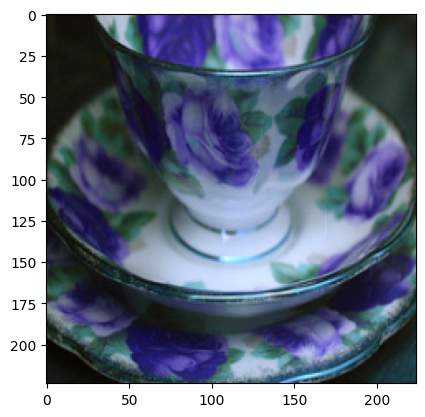

In [38]:
plt.imshow(x[2])

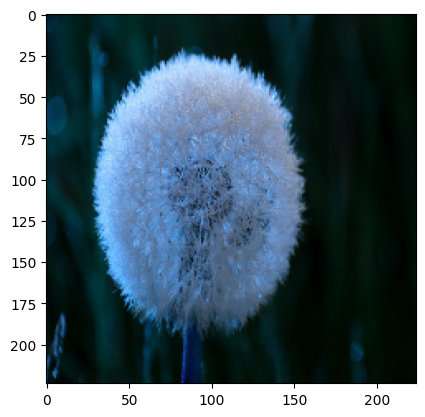

In [39]:
plt.imshow(X_train[10])

In [40]:
IMAGE_SHAPE = (224, 224)
IMAGE_SHAPE+(3, )

(224, 224, 3)

In [41]:
x0_resized = cv2.resize(x[0], IMAGE_SHAPE)
x1_resized = cv2.resize(x[1], IMAGE_SHAPE)
x2_resized = cv2.resize(x[2], IMAGE_SHAPE)

**Making prediction of the flowers image with the pretrained model without any re training**

In [42]:
predict = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predict = np.argmax(predict, axis = 1)
predict

1/1 [==============================] - 0s 151ms/step


array([550, 795, 722])

In [43]:
labels[795-1]

'shower curtain'

**Re training the model with our specified requirements**

This is the same model -- >>**MobileNet V2 without the last layer**. Here we are going to train the model without adjusting the weights and only with the flower samples with us

In [44]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [45]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_5 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [46]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train, y_train,validation_split = 0.3, epochs=5)

Epoch 1/5
61/61 [==============================] - 113s 2s/step - loss: 0.8568 - acc: 0.6817 - val_loss: 0.6143 - val_acc: 0.7603
Epoch 2/5
61/61 [==============================] - 105s 2s/step - loss: 0.4254 - acc: 0.8567 - val_loss: 0.4728 - val_acc: 0.8269
Epoch 3/5
61/61 [==============================] - 105s 2s/step - loss: 0.3210 - acc: 0.9065 - val_loss: 0.4415 - val_acc: 0.8511
Epoch 4/5
61/61 [==============================] - 93s 2s/step - loss: 0.2682 - acc: 0.9195 - val_loss: 0.4044 - val_acc: 0.8547
Epoch 5/5
61/61 [==============================] - 92s 2s/step - loss: 0.2231 - acc: 0.9382 - val_loss: 0.3878 - val_acc: 0.8608


In [47]:
model.evaluate(X_test, y_test)

29/29 [==============================] - 31s 1s/step - loss: 0.4376 - acc: 0.8453


[0.4375816881656647, 0.8453159332275391]

In [49]:
#Simple function for exploring the data  in the dataset with their classes
def plot_image_verify(x, y_test,y_pred, index):
  y_pred_act = []
  for i in y_pred:
    y_pred_act.append(np.argmax(i))
  plt.figure(figsize = (20, 4))
  plt.imshow(x[index])
  pred_ans = y_pred_act[index]
  Key_pred = [key for key, value in flower_classes.items() if value == pred_ans] 
  plt.title(f"Predicted Result : {Key_pred[0].title()}")
  act_ans = y_test[index]
  Key_act = [key for key, value in flower_classes.items() if value == act_ans] 
  plt.xlabel(f"Actual Result : {Key_act[0].title()}")

In [48]:
y_pred = model.predict(X_test)

29/29 [==============================] - 32s 1s/step


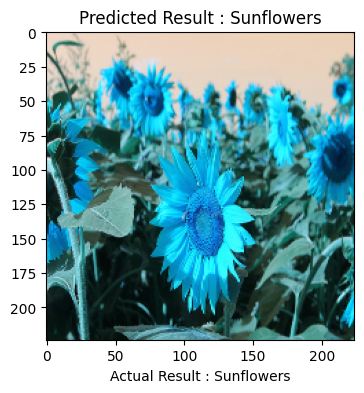

In [52]:
plot_image_verify(X_test, y_test, y_pred, 105)